# **Import Packages**

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import chi2, SelectKBest, VarianceThreshold
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import skew
import time


# **Utility Functions**

In [26]:
# Define utility functions
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test,y_pred) * 100
    return mae, mape, rmse, r2


def preprocess_data(df, target_col, dataset_name=None):
    """
    Preprocess the data: handle missing values, encode categorical variables, and ensure consistent types.
    Allows dataset-specific preprocessing if `dataset_name` is provided.
    """
    # Drop rows with missing values
    df = df.dropna()

    # Dataset-specific preprocessing
    if dataset_name == "Video Games":
        df = df.drop("Name", axis=1)

    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Convert target column to numeric if necessary
    try:
        y = pd.to_numeric(y, errors='coerce')
    except ValueError:
        raise ValueError(f"The target column '{target_col}' contains non-numeric values.")


    # Ensure consistent types for each column
    for col in X.columns:
        if X[col].dtype == 'object':
            try:
                # Attempt to convert to numeric if possible
                X[col] = pd.to_numeric(X[col])
            except ValueError:
                pass

    # Identify categorical columns
    categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

    # Label encode columns with few unique values, one-hot encode the rest
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        if X[col].nunique() <= 10:
            X[col] = label_encoder.fit_transform(X[col].astype(str))
        else:
            X = pd.get_dummies(X, columns=[col], drop_first=True)

    # Clean column names
    X.columns = [str(col).replace(" ", "_").replace("[", "").replace("]", "").replace("<", "").replace(">", "")
                 for col in X.columns]

    return X, y


# **Features Selection**

In [27]:

def feature_selection_correlation(X, threshold=0.85):
    """Remove highly correlated features."""
    corr_matrix = X.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    X = X.drop(to_drop, axis=1)
    return X

def feature_selection_variance(X, threshold=0.001):
    """Remove low-variance features."""
    selector = VarianceThreshold(threshold)
    X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])
    return X


In [28]:
def optimize_correlation_feature_selection(X, y):
    """
    Optimize feature selection by testing correlation thresholds.

    Parameters:
    X (pd.DataFrame): Input feature matrix.
    y (pd.Series): Target variable.

    Returns:
    pd.DataFrame: Feature matrix after applying the best threshold.
    float: Best threshold value.
    """

    thresholds = np.arange(0.6, 1.0, 0.1).round(2).tolist()  # Correlation thresholds
    best_score = float('-inf')
    best_X = None
    best_threshold = None

    for threshold in thresholds:
        print(f"Testing correlation threshold: {threshold}")
        selected_X = feature_selection_correlation(X.copy(), threshold)
        X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.2, random_state=42)
        mae, mape, rmse, r2 = evaluate_model(baseline_model, X_train, X_test, y_train, y_test)
        print(f"r2 at correlation threshold {threshold}: {r2}")

        if r2 > best_score:
            best_score = r2
            best_X = selected_X
            best_threshold = threshold

    print(f"Best correlation threshold: {best_threshold} with score: {best_score}")
    return best_X, best_threshold


In [31]:

def optimize_categorical_feature_selection(X, y, thresholds=[0.01, 0.05, 0.1, 0.001]):
    """
    Optimize categorical feature selection using the Chi-Square test.

    Parameters:
    X (pd.DataFrame): Feature matrix including categorical features.
    y (pd.Series): Target variable.
    thresholds (list): List of p-value thresholds to test.

    Returns:
    pd.DataFrame: Best feature-selected dataset.
    float: Best Chi-Square threshold.
    """
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) == 0:
        return X, None  # No categorical features to process

    X_encoded = X.copy()

    # Label encode categorical features
    for col in categorical_cols:
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

    # Normalize features (Chi-Square test works better on scaled data)
    X_scaled = MinMaxScaler().fit_transform(X_encoded[categorical_cols])

    best_score = float('-inf')
    best_X = None
    best_threshold = None

    for threshold in thresholds:
        chi2_scores, p_values = chi2(X_scaled, y)
        selected_features = categorical_cols[p_values < threshold]

        # Keep only selected categorical features
        X_selected = X_encoded[selected_features].copy()

        # Evaluate model performance
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        mae, mape, rmse, r2 = evaluate_model(baseline_model, X_train, X_test, y_train, y_test)

        if r2 > best_score:
            best_score = r2
            best_X = X_selected
            best_threshold = threshold

    return best_X, best_threshold


In [34]:
def optimize_variance_feature_selection(X, y):
    """
    Optimize feature selection by testing variance thresholds.

    Parameters:
    X (pd.DataFrame): Input feature matrix.
    y (pd.Series): Target variable.
    evaluate_model (callable): Function to evaluate feature set (should accept X, y and return a score).

    Returns:
    pd.DataFrame: Feature matrix after applying the best threshold.
    float: Best threshold value.
    """
    thresholds = [0.0001, 0.001, 0.01, 0.05]  # Variance thresholds
    best_score = float('-inf')
    best_X = None
    best_threshold = None

    for threshold in thresholds:
        selected_X = feature_selection_variance(X.copy(), threshold)
        X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.2, random_state=42)
        mae, mape, rmse, r2 = evaluate_model(baseline_model, X_train, X_test, y_train, y_test)

        if r2 > best_score:
            best_score = r2
            best_X = selected_X
            best_threshold = threshold

    return best_X, best_threshold


# **Features Engineering**

In [35]:
def create_interaction_and_transform_features(X, y=None, skew_threshold=0.75, evaluate_model=None):
    """
    Create interaction features and apply transformations to improve model performance.

    Parameters:
    X (pd.DataFrame): Input feature matrix.
    y (pd.Series or None): Target variable (optional, required if `evaluate_model` is provided).
    skew_threshold (float): Threshold above which features are considered skewed.
    evaluate_model (callable or None): Function to evaluate feature set (should accept X, y and return a score).

    Returns:
    pd.DataFrame: Transformed feature matrix.
    """

    transformed_X = X.copy()

    # Apply transformations to skewed continuous features
    skewed_features = X.select_dtypes(include=['float64', 'int64']).apply(lambda x: skew(x.dropna()))
    skewed_features = skewed_features[skewed_features.abs() > skew_threshold].index

    for feature in skewed_features:
        transformed_X[f'{feature}_log'] = np.log1p(X[feature].clip(lower=0))
        transformed_X[f'{feature}_sqrt'] = np.sqrt(X[feature].clip(lower=0))
        transformed_X[f'{feature}_squared'] = X[feature] ** 2

    # Process time-based features
    time_features = X.select_dtypes(include=['datetime64', 'object']).columns
    for feature in time_features:
        if pd.api.types.is_datetime64_any_dtype(X[feature]):
            transformed_X[f'{feature}_year'] = X[feature].dt.year
            transformed_X[f'{feature}_month'] = X[feature].dt.month
            transformed_X[f'{feature}_day'] = X[feature].dt.day

    # Retain only features that improve model performance
    if evaluate_model and y is not None:
        initial_score = evaluate_model(X, y)
        improved_features = []
        for feature in transformed_X.columns.difference(X.columns):
            score = evaluate_model(transformed_X[[feature]], y)
            if score > initial_score:
                improved_features.append(feature)
        transformed_X = transformed_X[improved_features + list(X.columns)]

    return transformed_X


# **Run Experiment**

In [37]:
def run_experiment(baseline_model, datasets, target_cols):
    results = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for (dataset_name, df), target in zip(datasets.items(), target_cols):
        print(f"Processing dataset: {dataset_name}")

        X, y = preprocess_data(df, target, dataset_name)

        # Measure time for baseline model
        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        baseline_mae, baseline_mape, baseline_rmse, baseline_r2 = evaluate_model(baseline_model, X_train, X_test, y_train, y_test)
        baseline_time = time.time() - start_time

        # Feature Selection and Engineering
        X, _ = optimize_categorical_feature_selection(X, y)
        X, _ = optimize_correlation_feature_selection(X, y)
        X = create_interaction_and_transform_features(X, y)

        # Measure time for enhanced model
        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        enhanced_mae, enhanced_mape, enhanced_rmse, enhanced_r2 = evaluate_model(baseline_model, X_train, X_test, y_train, y_test)
        enhanced_time = time.time() - start_time

        # Record results
        results.append({
            "Dataset": dataset_name,
            "Baseline_MAE": baseline_mae,
            "Enhanced_MAE": enhanced_mae,
            "Baseline_MAPE": baseline_mape,
            "Enhanced_MAPE": enhanced_mape,
            "Baseline_RMSE": baseline_rmse,
            "Enhanced_RMSE": enhanced_rmse,
            "Baseline_R2": baseline_r2,
            "Enhanced_R2": enhanced_r2,
            "Baseline_Time": baseline_time,
            "Enhanced_Time": enhanced_time
        })

    return pd.DataFrame(results)


Processing dataset: Video Games
Testing correlation threshold: 0.6
r2 at correlation threshold 0.6: 0.6577730065213645
Testing correlation threshold: 0.7
r2 at correlation threshold 0.7: 0.6615334897625612
Testing correlation threshold: 0.8
r2 at correlation threshold 0.8: 0.6589527115394778
Testing correlation threshold: 0.9
r2 at correlation threshold 0.9: 0.6549027855400841
Best correlation threshold: 0.7 with score: 0.6615334897625612
Processing dataset: Property Sales
Testing correlation threshold: 0.6
r2 at correlation threshold 0.6: 0.9442959427833557
Testing correlation threshold: 0.7
r2 at correlation threshold 0.7: 0.9442959427833557
Testing correlation threshold: 0.8
r2 at correlation threshold 0.8: 0.9510796666145325
Testing correlation threshold: 0.9
r2 at correlation threshold 0.9: 0.9397664070129395
Best correlation threshold: 0.8 with score: 0.9510796666145325
Processing dataset: Car Prices
Testing correlation threshold: 0.6
r2 at correlation threshold 0.6: 0.9461567401

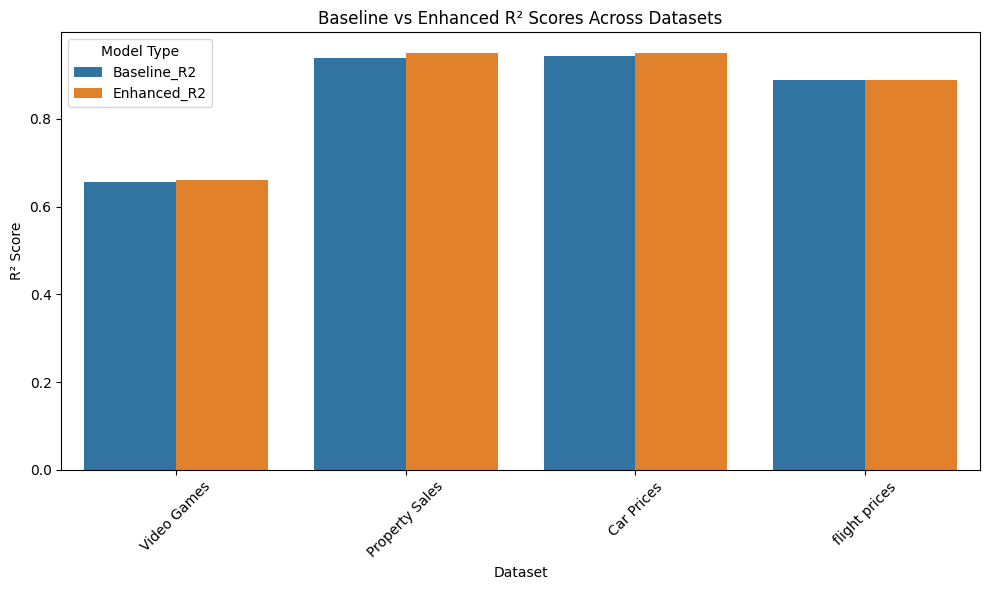

In [38]:

# Load datasets
datasets = {
     "Video Games": pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv"),
     "Property Sales": pd.read_csv("House Price India.csv"),
     "Car Prices": pd.read_csv("cars_data.csv"),
     "flight prices": pd.read_excel("Data_Train.xlsx"),
  }

# Target column and baseline model
target_cols = [
     "Critic_Score",
     "Price",
     "MSRP",
     "Price"
]
baseline_model = XGBRegressor(random_state=42)

# Run experiments
results = run_experiment(baseline_model, datasets, target_cols)

# Save and visualize results
results.to_csv("experiment_results.csv", index=False)

# Melt results for plotting
plot_data = results.melt(
    id_vars=["Dataset"],
    value_vars=["Baseline_R2", "Enhanced_R2"],
    var_name="Metric",
    value_name="R² Score"
)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Dataset", y="R² Score", hue="Metric", data=plot_data)
plt.title("Baseline vs Enhanced R² Scores Across Datasets")
plt.ylabel("R² Score")
plt.xlabel("Dataset")
plt.legend(title="Model Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# **Results**

In [44]:
file_path = "experiment_results.csv"
data = pd.read_csv(file_path)

In [45]:
# Compute improvements
def compute_improvements(data):
    return pd.DataFrame({
        "Dataset": data["Dataset"],
        "MAPE_Improvement": 100 * (data["Baseline_MAPE"] - data["Enhanced_MAPE"])/data["Baseline_MAPE"],
        "RMSE_Improvement": 100 * (data["Baseline_RMSE"] - data["Enhanced_RMSE"])/data["Baseline_RMSE"],
        "R2_Improvement": 100 * (data["Enhanced_R2"] - data["Baseline_R2"])/data["Baseline_R2"],
        "Time_Reduction": np.maximum(100 * (data["Baseline_Time"] - data["Enhanced_Time"]) / data["Baseline_Time"], 0)
    })


In [46]:
from matplotlib.ticker import MaxNLocator

def plot_improvements(improvements):
    metrics = ["MAPE_Improvement", "RMSE_Improvement", "R2_Improvement", "Time_Reduction"]
    titles = [
        "MAPE Improvement (%)",
        "RMSE Improvement (%)",
        "R² Improvement (%)",
        "Time Reduction (%)"
    ]

    num_metrics = len(metrics)
    x = np.arange(len(improvements["Dataset"]))
    width = 0.4

    fig, axs = plt.subplots(num_metrics, 1, figsize=(12, num_metrics * 4), constrained_layout=True)

    if num_metrics == 1:
        axs = [axs]

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        bars = axs[i].bar(x, improvements[metric], width, color="dodgerblue", edgecolor="black")
        axs[i].set_title(title, fontsize=16, fontweight="bold")
        axs[i].set_xlabel("Dataset", fontsize=14)
        axs[i].set_ylabel(metric.replace("_", " "), fontsize=14)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(improvements["Dataset"], rotation=30, ha="right", fontsize=12)
        axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i].grid(axis="y", linestyle="--", alpha=0.6)

        # Annotate bars
        for bar in bars:
            height = bar.get_height()
            axs[i].annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha="center", va="bottom", fontsize=10, color="black")

    plt.show()

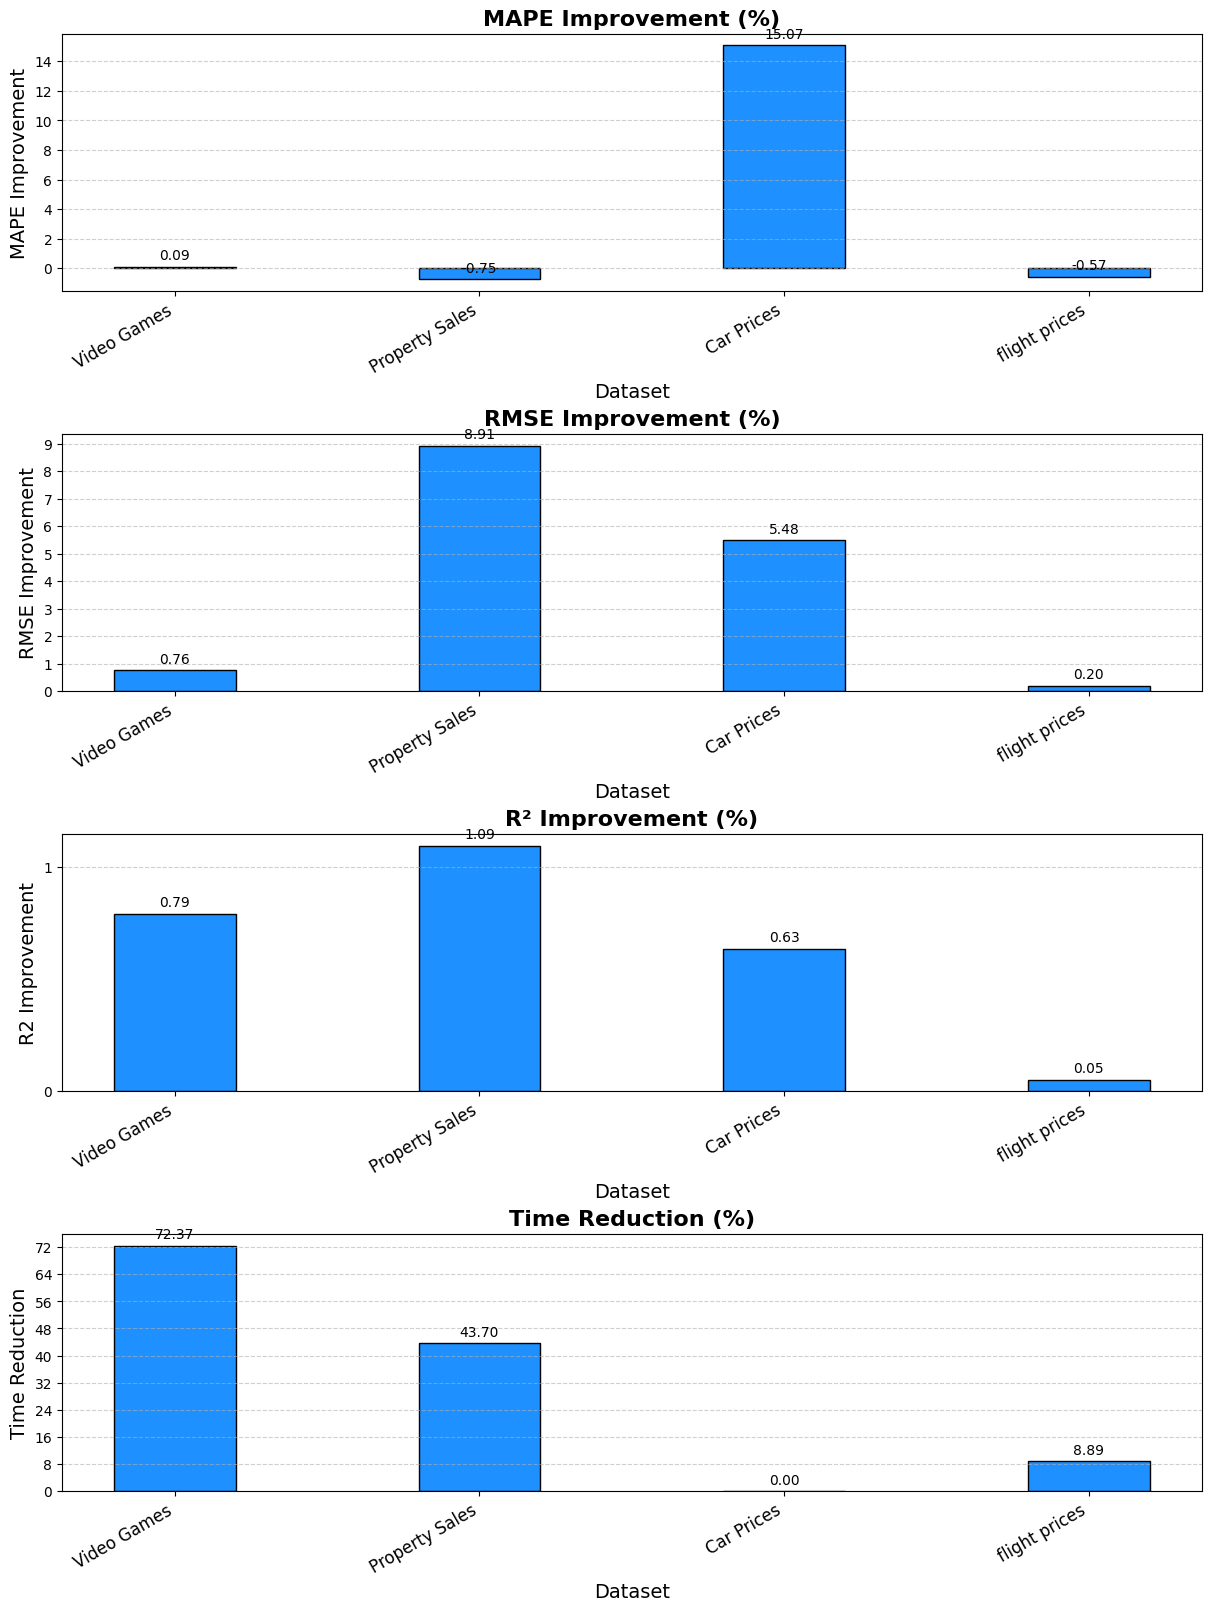

In [47]:
improvements = compute_improvements(data)
plot_improvements(improvements)